In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [55]:
res_list = [10]

## Load data

<Axes: >

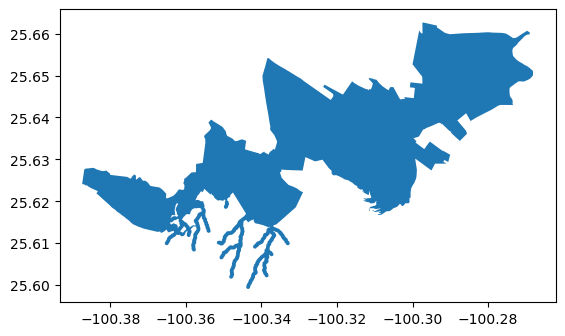

In [25]:
# Polígono del proyecto que ellos tienen originalmente
aoi_name = 'poligono_arroyovivo'

aoi_dir = f'../../data/external/temporal_todocker/arroyo_vivo/poligono_proyectoarroyovivo_32614.gpkg'
aoi = gpd.read_file(aoi_dir)
aoi = aoi.to_crs("EPSG:4326")

aoi = aoi[['geometry']]

# Show
aoi.plot()

### Load data - Population

In [16]:
schema = 'censo'
table = 'nodes_pop_2020'

nodes_pop_aoi = aup.gdf_from_polygon(aoi,schema,table)

# Show
print(nodes_pop_aoi.shape)
nodes_pop_aoi.head(1)

(5410, 240)


,x,y,street_count,geometry,cve_geo,cve_ent,cve_mun,cve_loc,cve_ageb,entidad,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic,cve_geo_ageb
0,-100.296978,25.659477,3,POINT (-100.29698 25.65948),1903900012010,19,039,0001,2010,19,...,0.166667,0.15873,0.095238,0.075397,0.035714,NaN,0.0,0.011905,0.0,1903900012010


### Load data - Marg

In [9]:
schema = 'censo'
table = 'nodes_marg_2020'

nodes_marg_aoi = aup.gdf_from_polygon(aoi,schema,table)

# Show
print(nodes_marg_aoi.shape)
nodes_marg_aoi.head(1)

(5410, 31)


,x,y,street_count,geometry,cve_geo_ageb,cve_ent,cve_mun,cve_loc,cve_ageb,CVE_AGEB,...,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,-100.296978,25.659477,0,POINT (-100.29698 25.65948),1903900012010,19,039,0001,2010,1903900012010,...,0.0,0.0,0.0,0.009839,0.0,0.013118,0.006559,0.0,117.874636,0.920792


## Process data

In [89]:
# Simplify aoi geometry with buffer
aoi_2 = aoi.to_crs("EPSG:6372")
aoi_2 = aoi_2.buffer(300)
aoi_2 = aoi_2.to_crs("EPSG:4326")
aoi_2 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(aoi_2))

# Create hexgrid
hex_gdf = aup.create_hexgrid(aoi_2, res)
hex_gdf = hex_gdf.set_crs("EPSG:4326")
print(f"Created hex_grid with resolution {res}")

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

Created hex_grid with resolution 10
(2348, 2)


,hex_id_10,geometry
0,8a48a2158c6ffff,"POLYGON ((-100.35700 25.60679, -100.35632 25.6..."


### Process data - pop to hex

In [57]:
# View columns
#list(nodes_pop_aoi.columns)

# Filter pop data
nodes_pop_aoi_f = nodes_pop_aoi[['pobtot','graproes','geometry']]

# Show
nodes_pop_aoi_f.head(1)

,pobtot,graproes,geometry
0,1.496032,12.78,POINT (-100.29698 25.65948)


Created hex_grid with 10 resolution
Agregated socio data to hex with a total of 98893.7109375 population for resolution 10
Calculated an average density of 52.46494316253374
(1076, 5)


<Axes: >

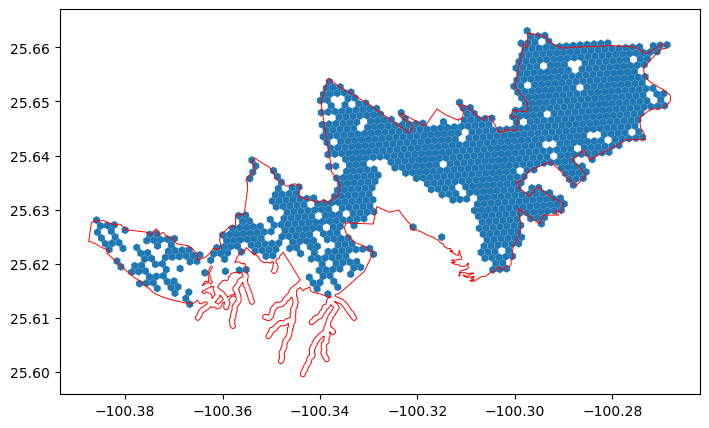

In [87]:
# CREATE HEXGRID ----------------------------------------------------------------------------------
hex_gdf = aup.create_hexgrid(aoi_2, res)
hex_gdf = hex_gdf.set_crs("EPSG:4326")

print(f"Created hex_grid with {res} resolution")

# GROUP CENSUS DATA -------------------------------------------------------------------------------
# Column variables for grouping analysis
string_columns = []
avg_column = ["graproes"]
wgt_dict = {"graproes":'pobtot'}

# Group centroids by hexagon
hex_socio_df = aup.socio_points_to_polygon(hex_gdf,nodes_pop_aoi_f,f'hex_id_{res}',
                                           string_columns, wgt_dict=wgt_dict, avg_column=avg_column)
print("Agregated socio data to hex with a total " +
        f"of {hex_socio_df.pobtot.sum()} population " +
        f"for resolution {res}")

# Hexagons to GeoDataFrame
hex_gdf_socio = hex_gdf.merge(hex_socio_df, on=f'hex_id_{res}')

# Calculate density
hectares = hex_gdf_socio.to_crs("EPSG:6372").area / 10000
hex_gdf_socio['dens_pob_ha'] = hex_gdf_socio['pobtot'] / hectares
print(f"Calculated an average density of {hex_gdf_socio.dens_pob_ha.mean()}")

# Show
print(hex_gdf_socio.shape)

fig,ax = plt.subplots(figsize=(10,5))
hex_gdf_socio.plot(ax=ax,zorder=1)
aoi.plot(ax=ax,zorder=2,facecolor="none", edgecolor='red', lw=0.7)

### Process data - marg to hex

In [62]:
# View columns
#list(nodes_marg_aoi.columns)

# Filter pop data
nodes_marg_aoi_f = nodes_marg_aoi[['im_2020','geometry']]

# Show
nodes_marg_aoi_f.head(1)

,im_2020,geometry
0,117.874636,POINT (-100.29698 25.65948)


<Axes: >

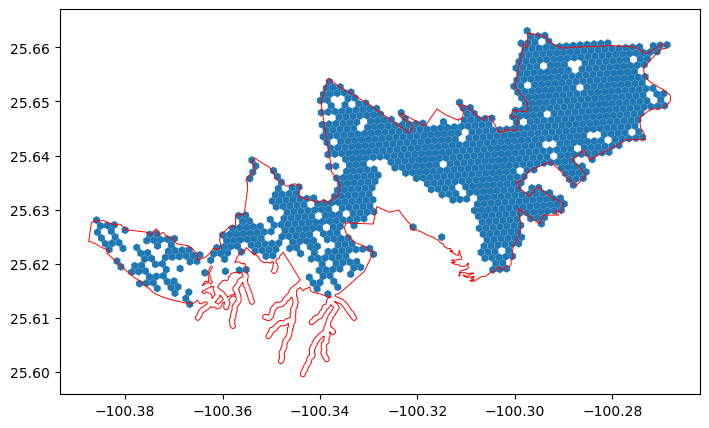

In [74]:
# GROUP MARG DATA -------------------------------------------------------------------------------
# Assign hex to points
nodes_marg_hex = gpd.sjoin(nodes_marg_aoi_f,hex_gdf,how='left')

# Group by data
groupby = nodes_marg_hex.groupby('hex_id_10').agg({'im_2020':np.mean})

# Merge back to geometry
hex_gdf_marg = pd.merge(hex_gdf,groupby, on='hex_id_10')

# Show
fig,ax = plt.subplots(figsize=(10,5))
hex_gdf_marg.plot(ax=ax,zorder=1)
aoi.plot(ax=ax,zorder=2,facecolor="none", edgecolor='red', lw=0.7)

In [92]:
merge_1 = pd.merge(hex_gdf, hex_gdf_socio[['hex_id_10','pobtot','graproes','dens_pob_ha']],how='left',on='hex_id_10')
merge_1.shape

(2348, 5)

In [94]:
merge_2 = pd.merge(merge_1, hex_gdf_marg[['hex_id_10','im_2020']],how='left',on='hex_id_10')
merge_2.shape

(2348, 6)

In [95]:
merge_2

,hex_id_10,geometry,pobtot,graproes,dens_pob_ha,im_2020
0,8a48a2158c6ffff,"POLYGON ((-100.35700 25.60679, -100.35632 25.6...",NaN,NaN,NaN,NaN
1,8a48a2158137fff,"POLYGON ((-100.35780 25.60786, -100.35712 25.6...",NaN,NaN,NaN,NaN
2,8a48a215a7a7fff,"POLYGON ((-100.32729 25.62671, -100.32661 25.6...",NaN,NaN,NaN,NaN
3,8a48a215ab9ffff,"POLYGON ((-100.34029 25.62024, -100.33961 25.6...",10.919298,14.990001,6.231836,123.811710
4,8a48a20298e7fff,"POLYGON ((-100.31435 25.62533, -100.31367 25.6...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2343,8a48a215a397fff,"POLYGON ((-100.33518 25.62731, -100.33450 25.6...",18.547171,15.240000,10.585474,124.085919
2344,8a48a2029257fff,"POLYGON ((-100.31705 25.64085, -100.31637 25.6...",274.950775,13.342003,156.939013,125.446309
2345,8a48a202b72ffff,"POLYGON ((-100.28321 25.64533, -100.28254 25.6...",184.251770,14.282728,105.189941,125.223322
2346,8a48a215ab6ffff,"POLYGON ((-100.34880 25.61968, -100.34812 25.6...",NaN,NaN,NaN,NaN
